# Proiect final SDP 
# Tema lucrarii : Paralelizare în limbajul python : libraria Dask

Setul de date se gaseste la adresa https://catalog.data.gov/dataset/arrest-data-from-2020-to-present

Datele se refera la numarul persoane arestate in Los Angeles(S.U.A.) incepand cu data de 01.01.2020 

In [1]:
%pip install "dask[complete]"

     |████████████████████████████████| 112kB 4.0MB/s 
     |████████████████████████████████| 675kB 5.4MB/s 
ERROR: distributed 2021.3.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.3.0 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


Importul librariilor 

In [2]:
import numpy as np 
import pandas as pd 

import dask 
import dask.array as da
import dask.dataframe as dd
import dask.delayed as delayed
import datetime
from datetime import datetime

# Calculul pentru timpul scurs pentru citirea fisierului .csv

Libraria pandas 

In [3]:
times_start = datetime.now()
dfPandas = pd.read_csv('/content/Arrest_Data_from_2020_to_Present.csv')
time_elapsed = datetime.now () - times_start
print('Timpul scurs (hh:mm:ss.ms) = ',format(time_elapsed))

Timpul scurs (hh:mm:ss.ms) =  0:00:00.401094


Libraria dask

In [4]:
times_start = datetime.now()
dfDask = dd.read_csv('/content/Arrest_Data_from_2020_to_Present.csv', blocksize = '2 MB', dtype={'Time': 'float32', 'Age' : 'float32'} )
time_elapsed = datetime.now () - times_start
print('Timpul scurs (hh:mm:ss.ms) = ',format(time_elapsed))

Timpul scurs (hh:mm:ss.ms) =  0:00:00.035285


In [5]:
dfDask.npartitions

11

Din cele doua secvente de cod de mai sus se poate observa importul datelor in structurile de tip DataFrame a fost net superior in cazul librariei Dask.

In [6]:
dfDask.columns

Index(['Report ID', 'Report Type', 'Arrest Date', 'Time', 'Area ID',
       'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Disposition Description', 'Address',
       'Cross Street', 'LAT', 'LON', 'Location', 'Booking Date',
       'Booking Time', 'Booking Location', 'Booking Location Code'],
      dtype='object')

# Cateva date statistice referitoare la setul de date 

In [7]:
import os 

numeFisier = '/content/Arrest_Data_from_2020_to_Present.csv'
marimeFisier = os.path.getsize(numeFisier)
print(f' Marimea fisierului .CSV este de {marimeFisier / (1024 * 1024)} MB')

 Marimea fisierului .CSV este de 19.351759910583496 MB


In [8]:
dfDask.info

<bound method DataFrame.info of Dask DataFrame Structure:
               Report ID Report Type Arrest Date     Time Area ID Area Name Reporting District      Age Sex Code Descent Code Charge Group Code Charge Group Description Arrest Type Code  Charge Charge Description Disposition Description Address Cross Street      LAT      LON Location Booking Date Booking Time Booking Location Booking Location Code
npartitions=11                                                                                                                                                                                                                                                                                                                                               
                   int64      object      object  float32   int64    object              int64  float32   object       object           float64                   object           object  object             object                  object  obje

In [9]:
dfDask.columns.size

25

In [10]:
dfDask.dtypes

Report ID                     int64
Report Type                  object
Arrest Date                  object
Time                        float32
Area ID                       int64
Area Name                    object
Reporting District            int64
Age                         float32
Sex Code                     object
Descent Code                 object
Charge Group Code           float64
Charge Group Description     object
Arrest Type Code             object
Charge                       object
Charge Description           object
Disposition Description      object
Address                      object
Cross Street                 object
LAT                         float64
LON                         float64
Location                     object
Booking Date                 object
Booking Time                float64
Booking Location             object
Booking Location Code       float64
dtype: object

In [11]:
dfPandas.shape

(73915, 25)

# Gruparea datelor

Am grupat tipul de raport dupa sex

Pandas

In [12]:
times_start = datetime.now()

dfPandas1 = dfPandas.groupby(['Sex Code'])['Report Type'].count()

time_elapsed = datetime.now () - times_start
print('Timpul scurs (hh:mm:ss.ms) = ',format(time_elapsed))

Timpul scurs (hh:mm:ss.ms) =  0:00:00.015892


In [13]:
dfPandas1

Sex Code
F    15266
M    58649
Name: Report Type, dtype: int64

Dask

In [14]:
times_start = datetime.now()

dfDask1 = dfDask.groupby(['Sex Code'])['Report Type'].count()

time_elapsed = datetime.now () - times_start
print('Timpul scurs (hh:mm:ss.ms) = ',format(time_elapsed))

Timpul scurs (hh:mm:ss.ms) =  0:00:00.010406


In [15]:
dfDask1

Dask Series Structure:
npartitions=1
    int64
      ...
Name: Report Type, dtype: int64
Dask Name: series-groupby-count-agg, 47 tasks

Si in acest caz se observa timpul superior de rulare a Dataframe-ului Dask 

Afisarea GRAFULUI  de taskuri

 - cercurile reprezinta taskurile sau functiile 
 - patratele reprezinta output-urile sau rezultatele

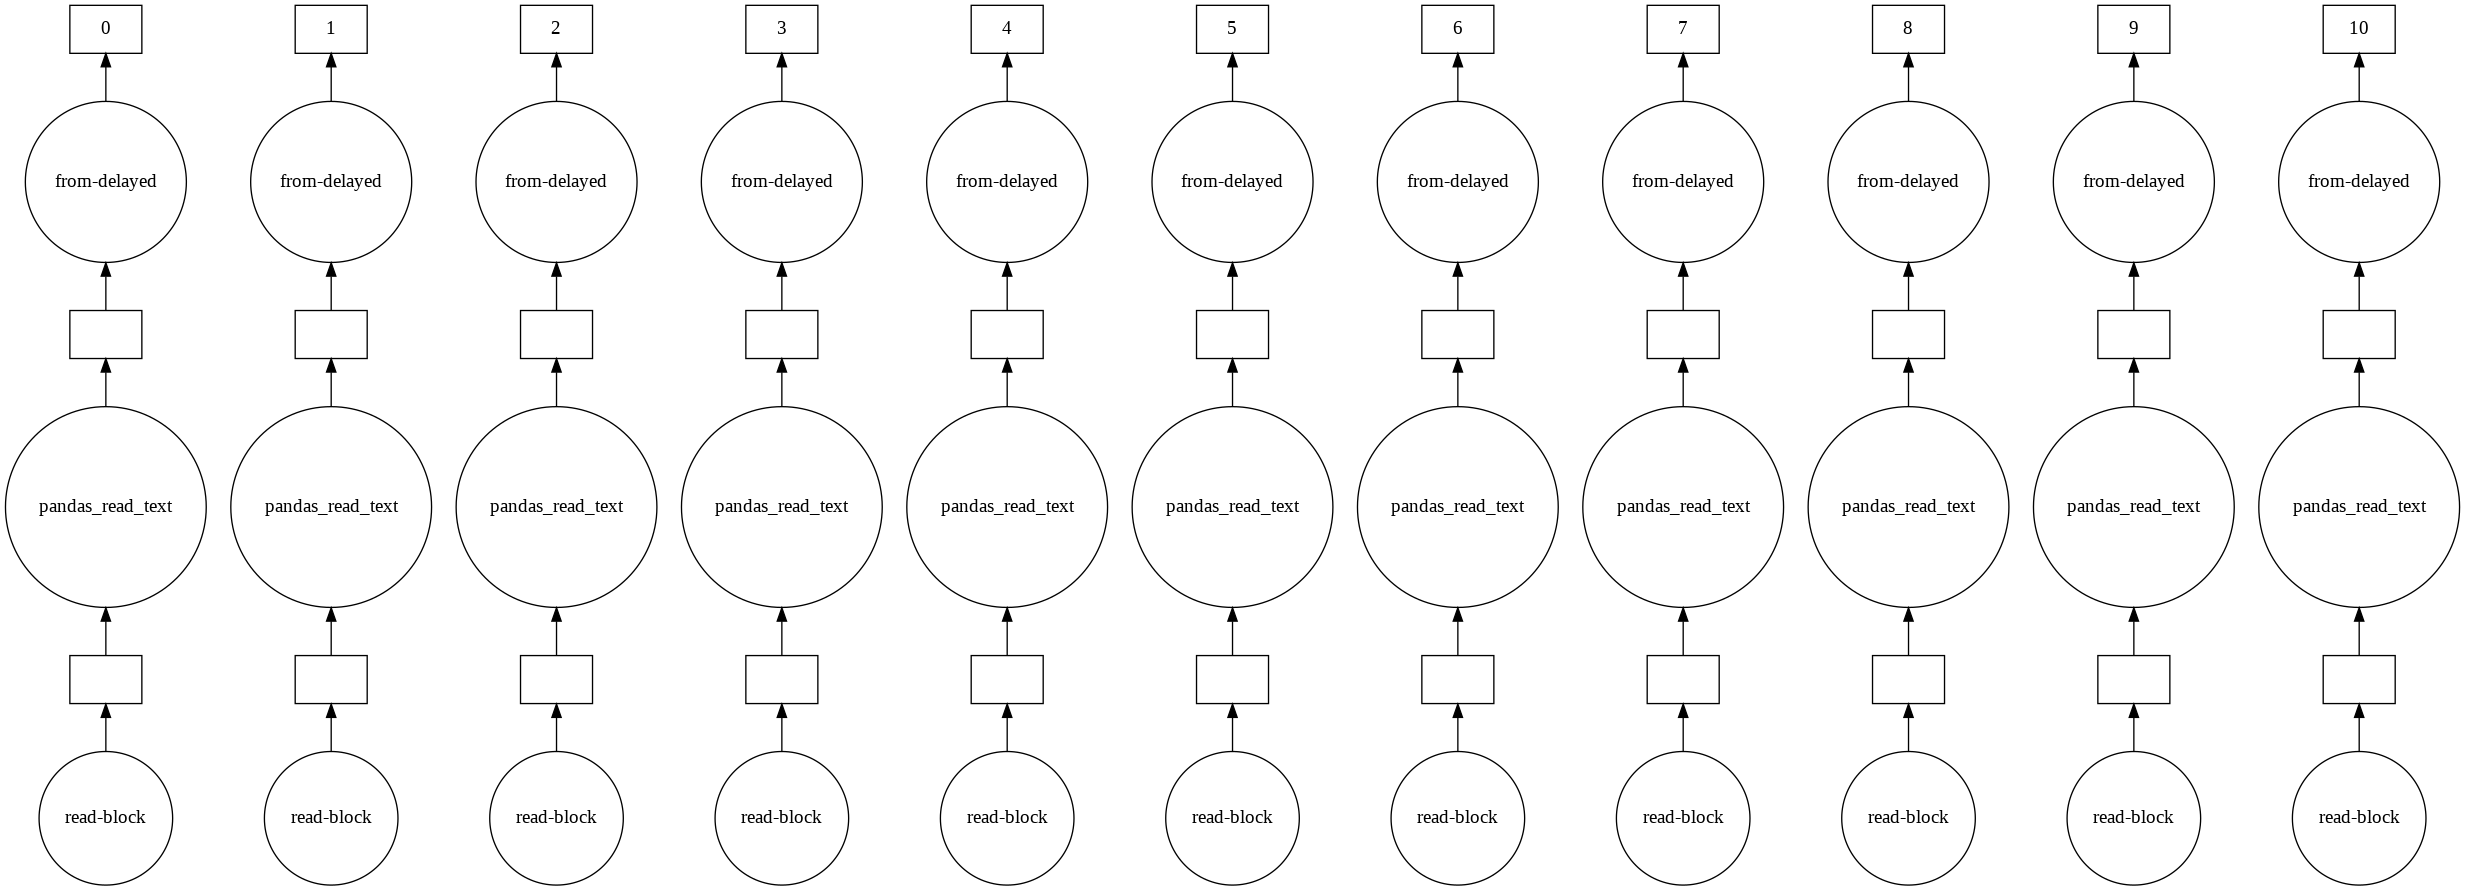

In [16]:
dfDask.visualize()

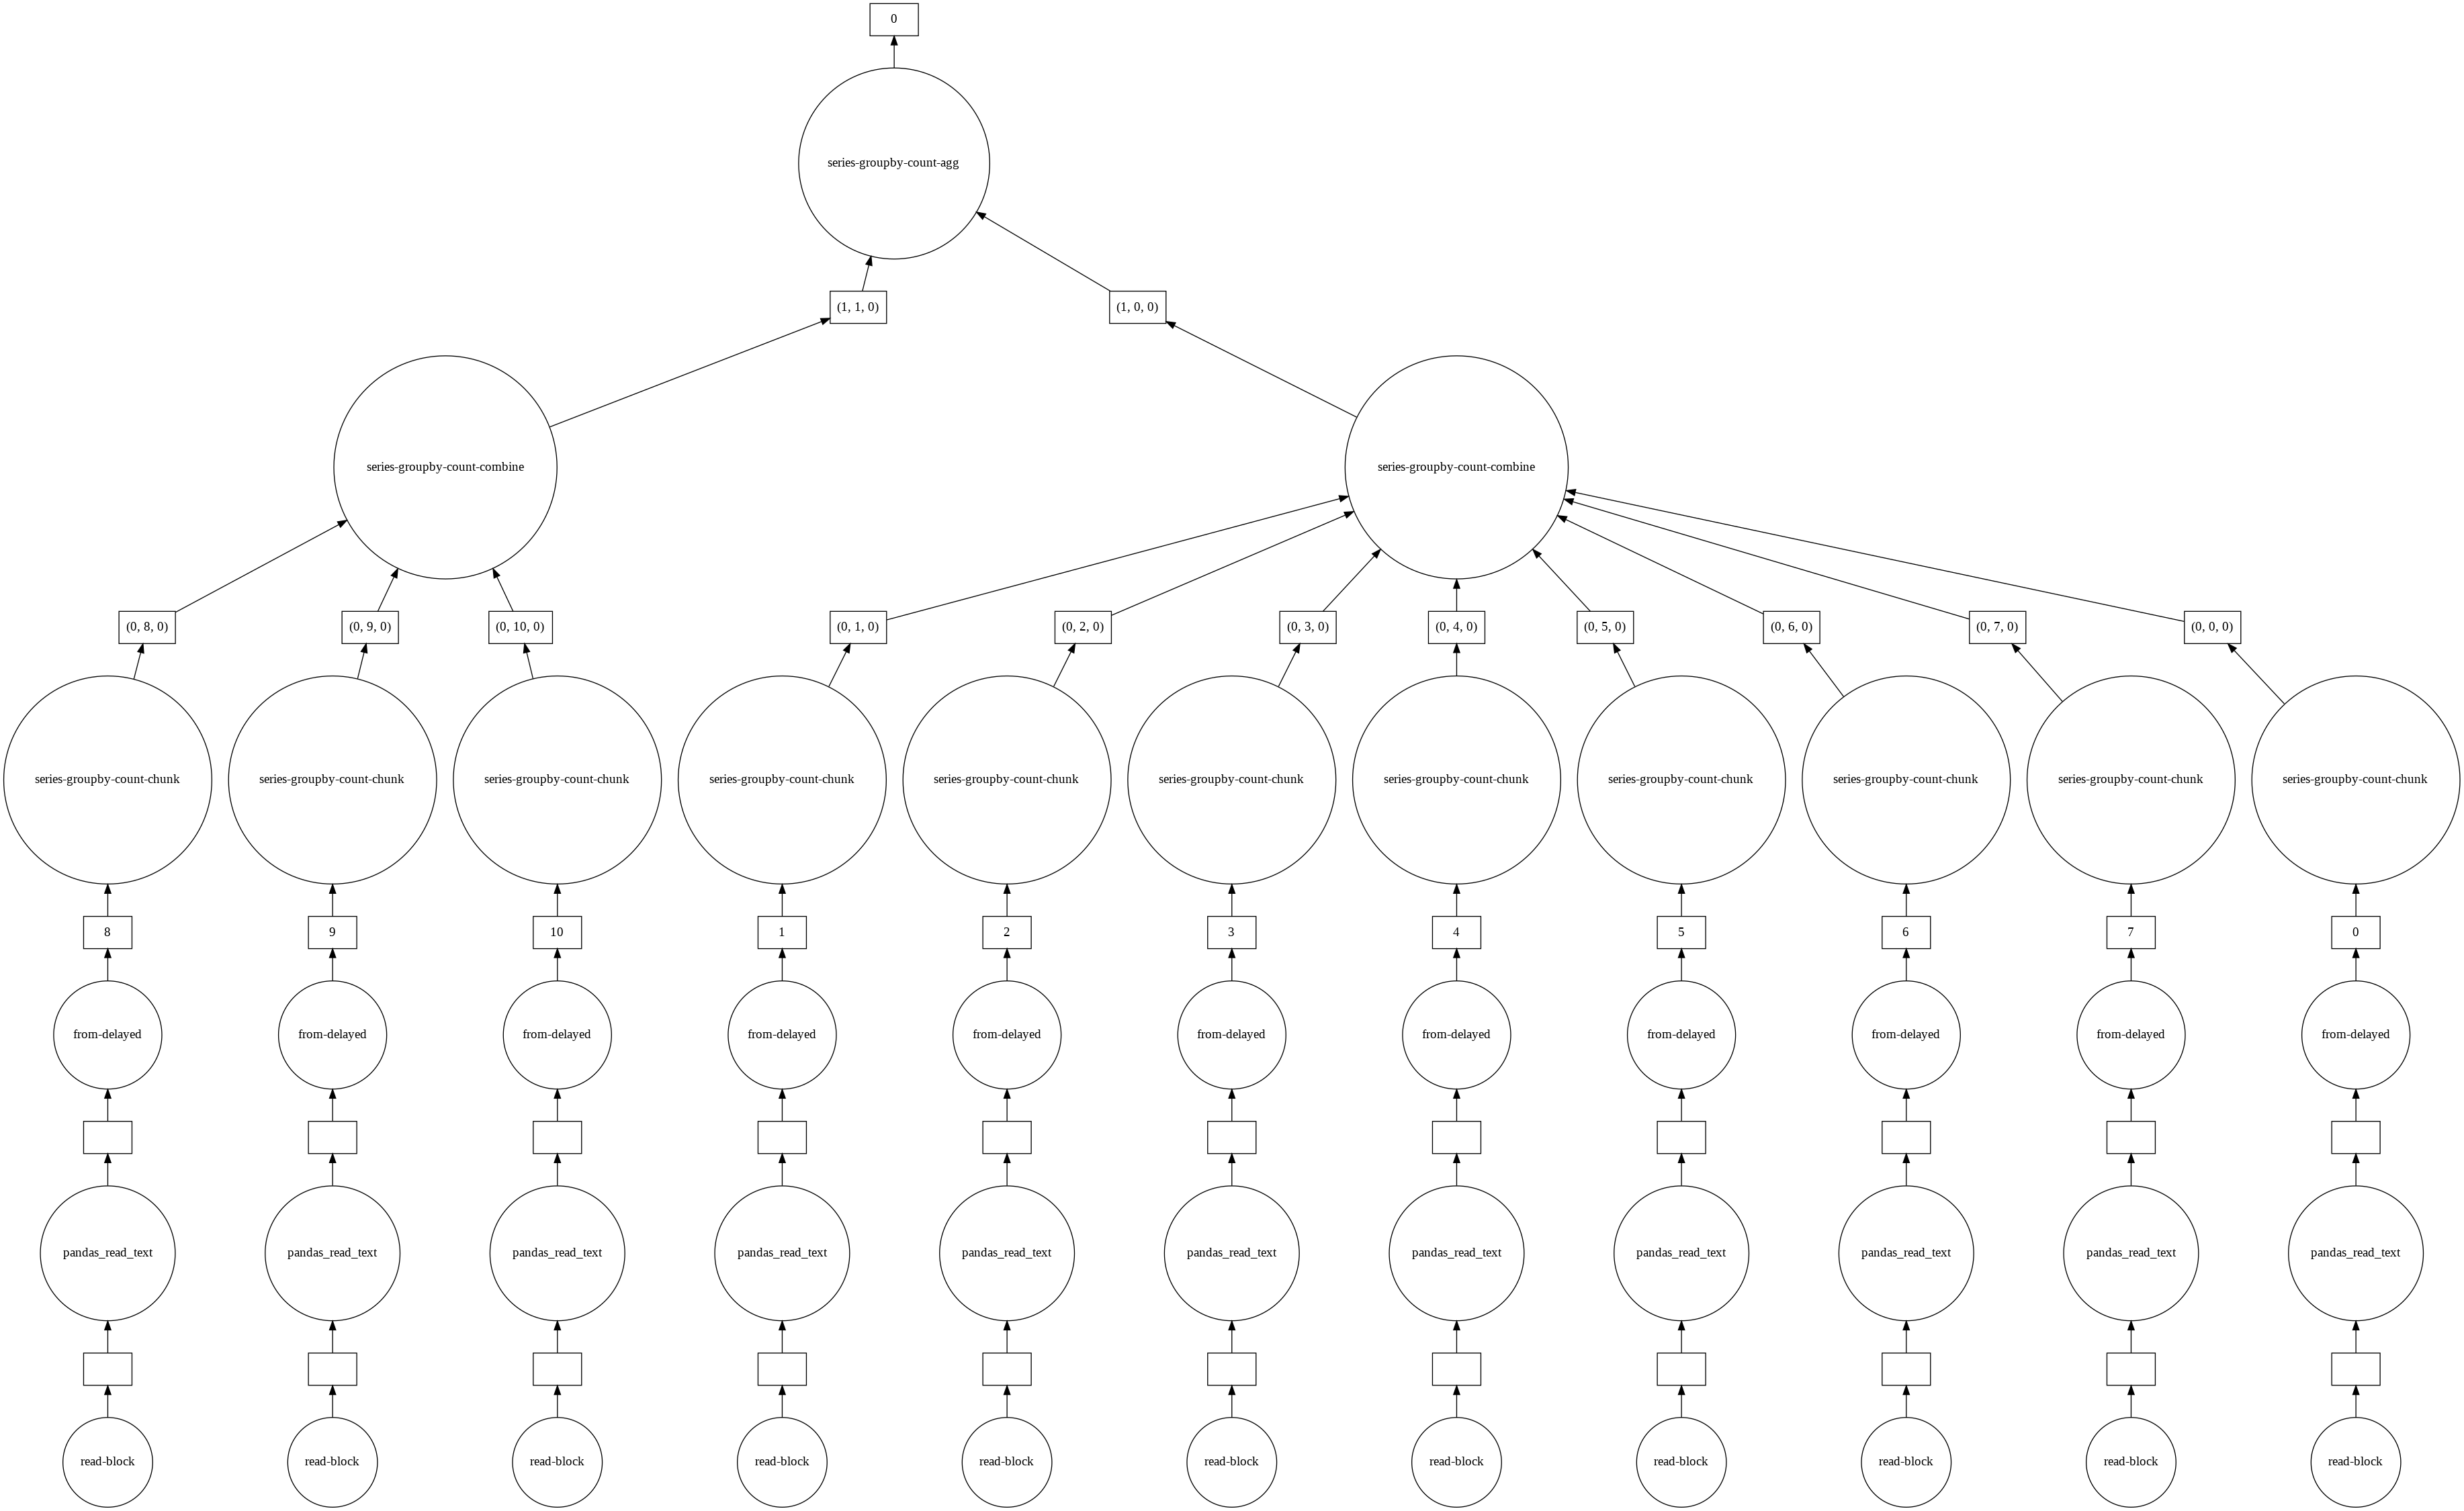

In [17]:
dfDask1.visualize()

# Partitionarea si indexarea dataframe-ului Dask

Un exemplu de diferente intre partitia 4 si partitia 5 a dataframe-ului dask

Partitia 4

In [18]:
dfDask2 = dfDask.get_partition(3)

In [19]:
dfDask2.index.min().compute()

0

In [20]:
dfDask2.index.max().compute()

7659

Partitia 5

In [21]:
dfDask3 = dfDask.get_partition(4)

In [22]:
dfDask3.index.min().compute()

0

In [23]:
dfDask3.index.max().compute()

7343

Din exemplele de mai sus se observa faptul ca nu exista un index comun care sa se intinda pe toate partitiile. 
Deci fiecare partitie are propriul sau index.
Aceasta inseamna ca nu putem diviza dataframe-ul dupa index. 

Totusi o solutie ar fi selectia unei coloane care poate fi folosita ca index, insa aceasta duce la un timp de rulare foarte mare, motiv pentru care este indicat sa se foloseasca decat o singura data. 

Pentru setul de date ales de catre mine am selectat ca index coloana "Report ID"

In [24]:
dfDask.divisions

(None, None, None, None, None, None, None, None, None, None, None, None)

In [25]:
dfDask4 = dfDask.set_index('Report ID')

In [26]:
dfDask4.divisions

(1062984,
 5859792,
 5893371,
 5919957,
 5960138,
 5984642,
 6022503,
 6054086,
 6105282,
 200207362,
 201405669,
 212105707)

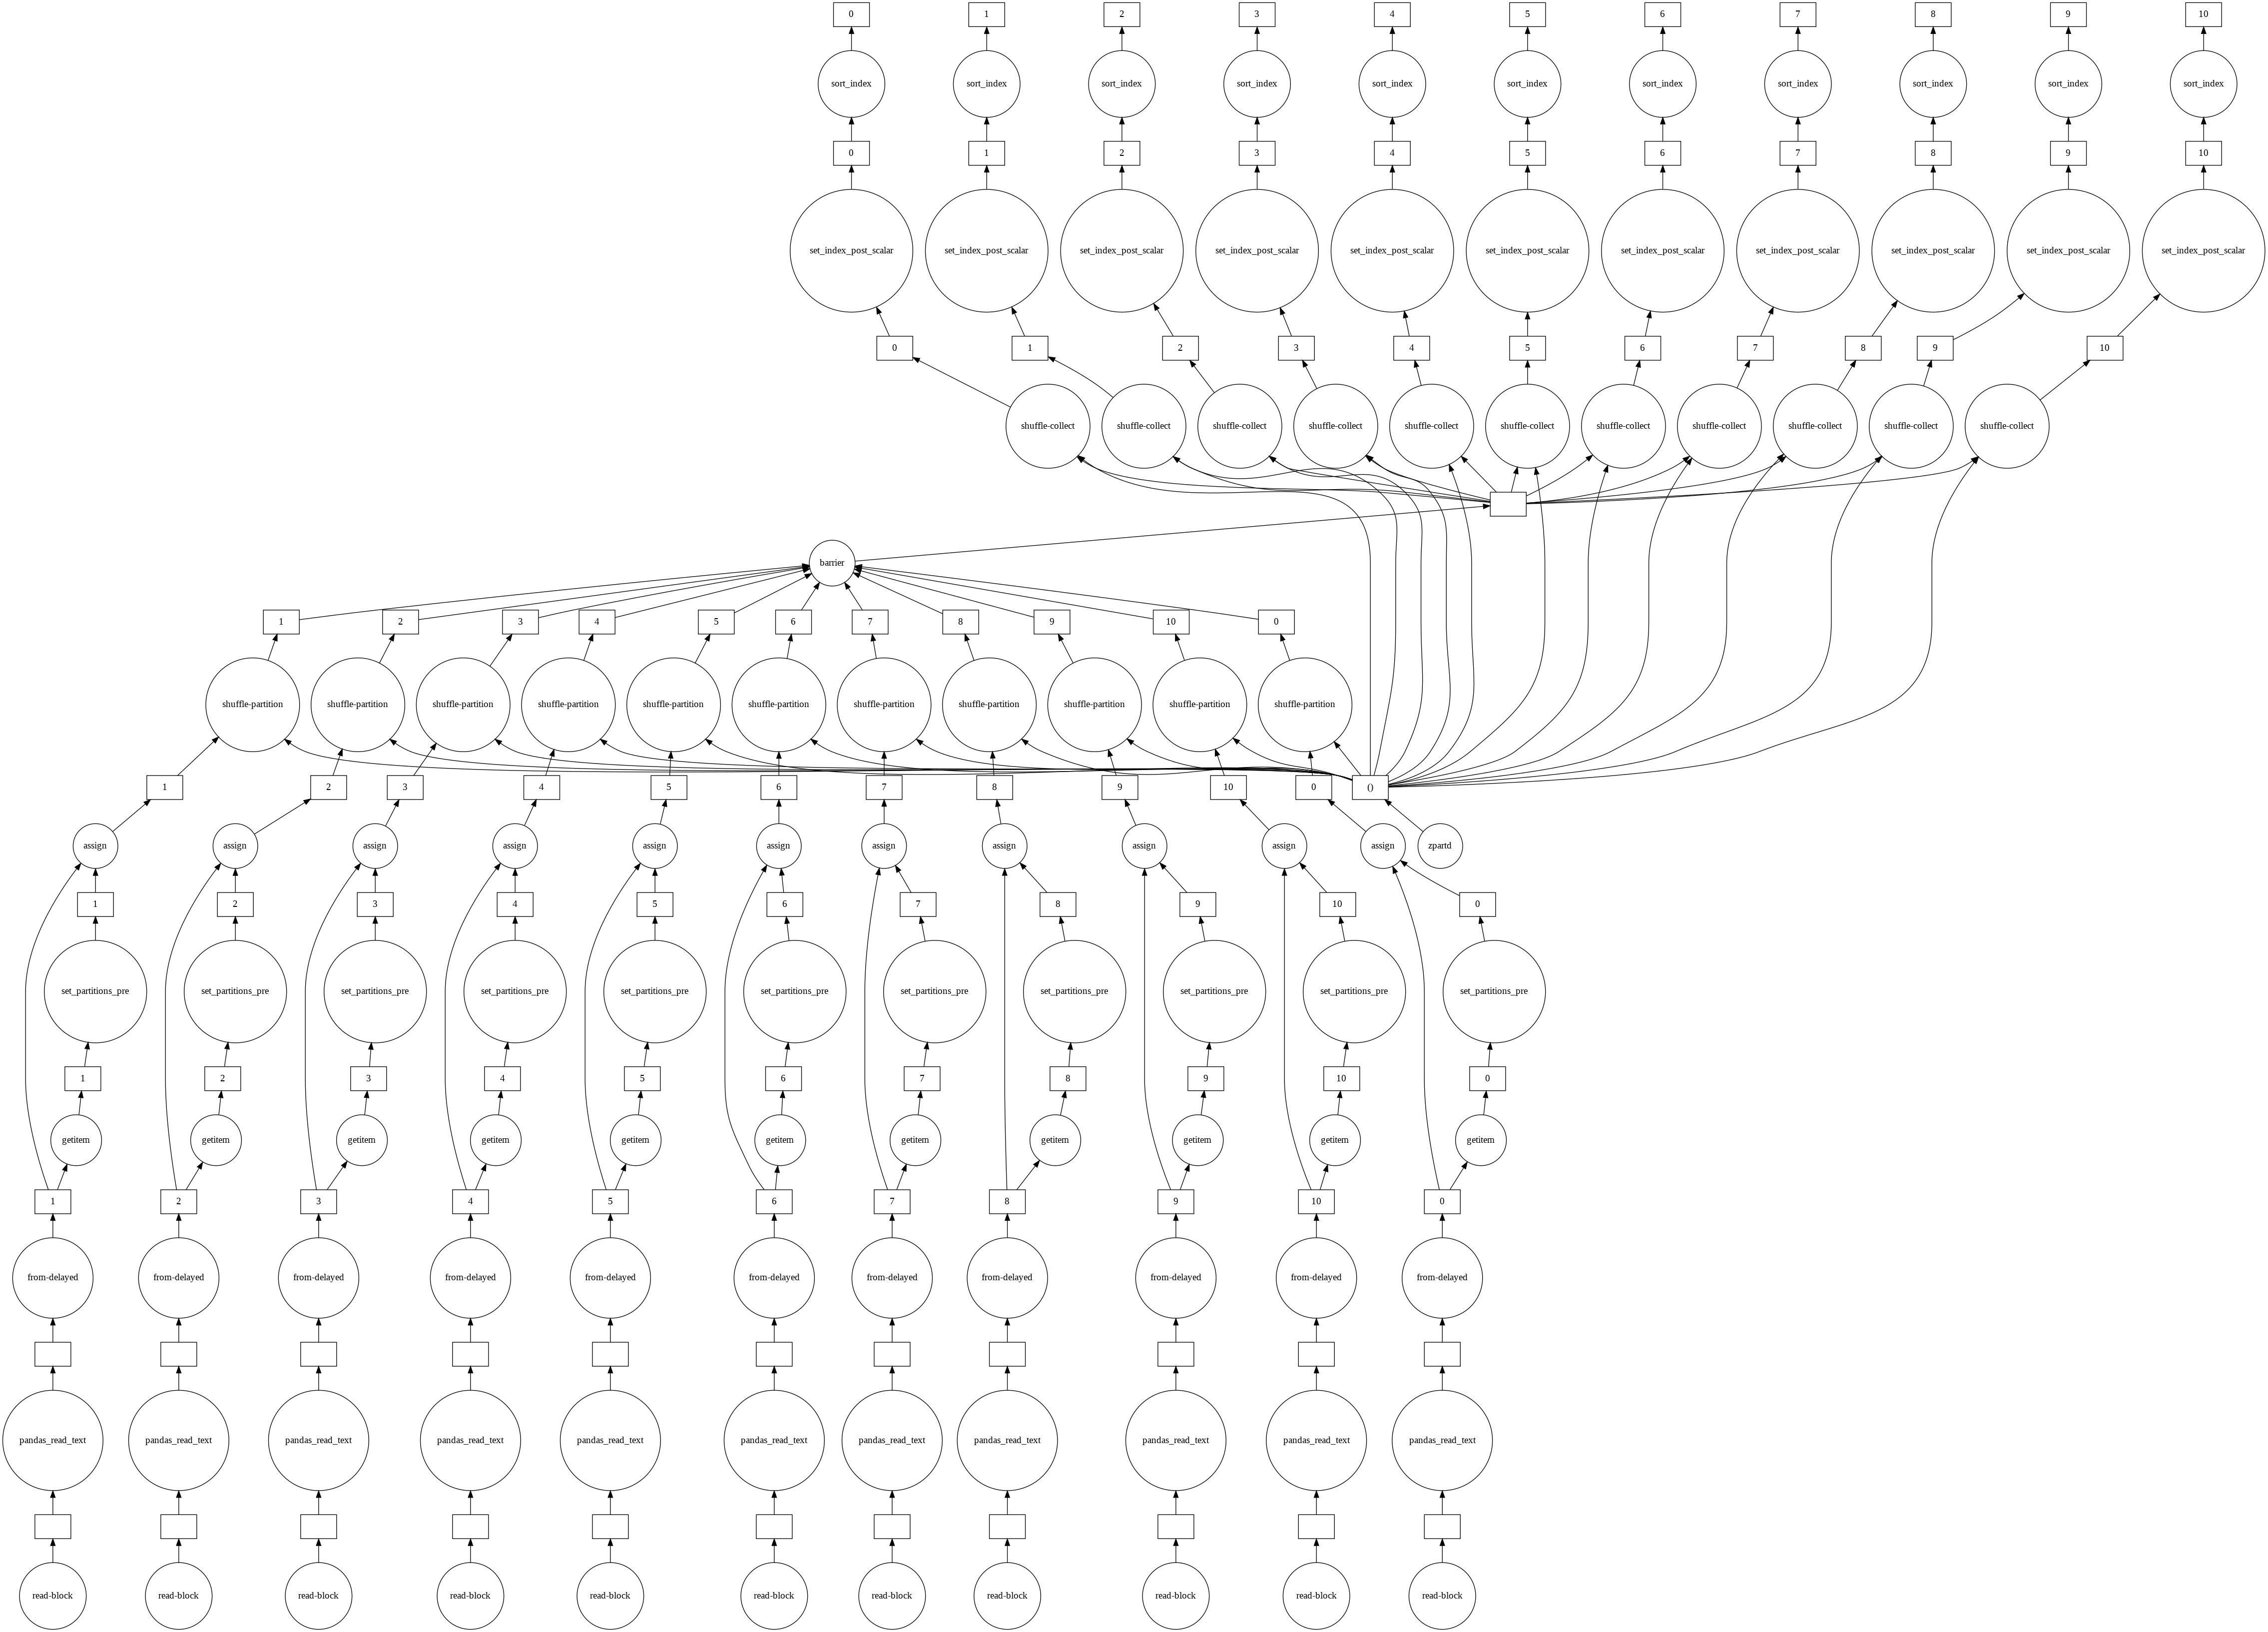

In [27]:
dfDask4.visualize()

# Curatarea datelor 

Pandas

In [28]:
times_start = datetime.now()

dfPandasClean = dfPandas.drop(['Time','Area ID','Area Name','Reporting District', 'Descent Code', 'Charge Group Code',
                               'Arrest Type Code', 'Charge', 'Charge Description', 'Disposition Description', 'Address',
                               'Cross Street', 'Location', 'Booking Date', 'Booking Time', 'Booking Location',
                               'Booking Location Code'], axis = 1).dropna()

time_elapsed = datetime.now () - times_start
print('Timpul scurs (hh:mm:ss.ms) = ',format(time_elapsed))

Timpul scurs (hh:mm:ss.ms) =  0:00:00.050405


In [29]:
print(dfPandasClean['Charge Group Description'])

1                           Liquor Laws
2                               Larceny
4                               Larceny
7                            Drunkeness
11                              Robbery
                      ...              
73910               Weapon (carry/poss)
73911                Aggravated Assault
73912                Aggravated Assault
73913    Miscellaneous Other Violations
73914               Weapon (carry/poss)
Name: Charge Group Description, Length: 68631, dtype: object


Dask

In [30]:
times_start = datetime.now()

dfDaskClean = dfDask.drop(['Time','Area ID','Area Name','Reporting District', 'Descent Code', 'Charge Group Code',
                               'Arrest Type Code', 'Charge', 'Charge Description', 'Disposition Description', 'Address',
                               'Cross Street', 'Location', 'Booking Date', 'Booking Time', 'Booking Location',
                               'Booking Location Code'], axis = 1).dropna()

time_elapsed = datetime.now () - times_start
print('Timpul scurs (hh:mm:ss.ms) = ',format(time_elapsed))

Timpul scurs (hh:mm:ss.ms) =  0:00:00.021948


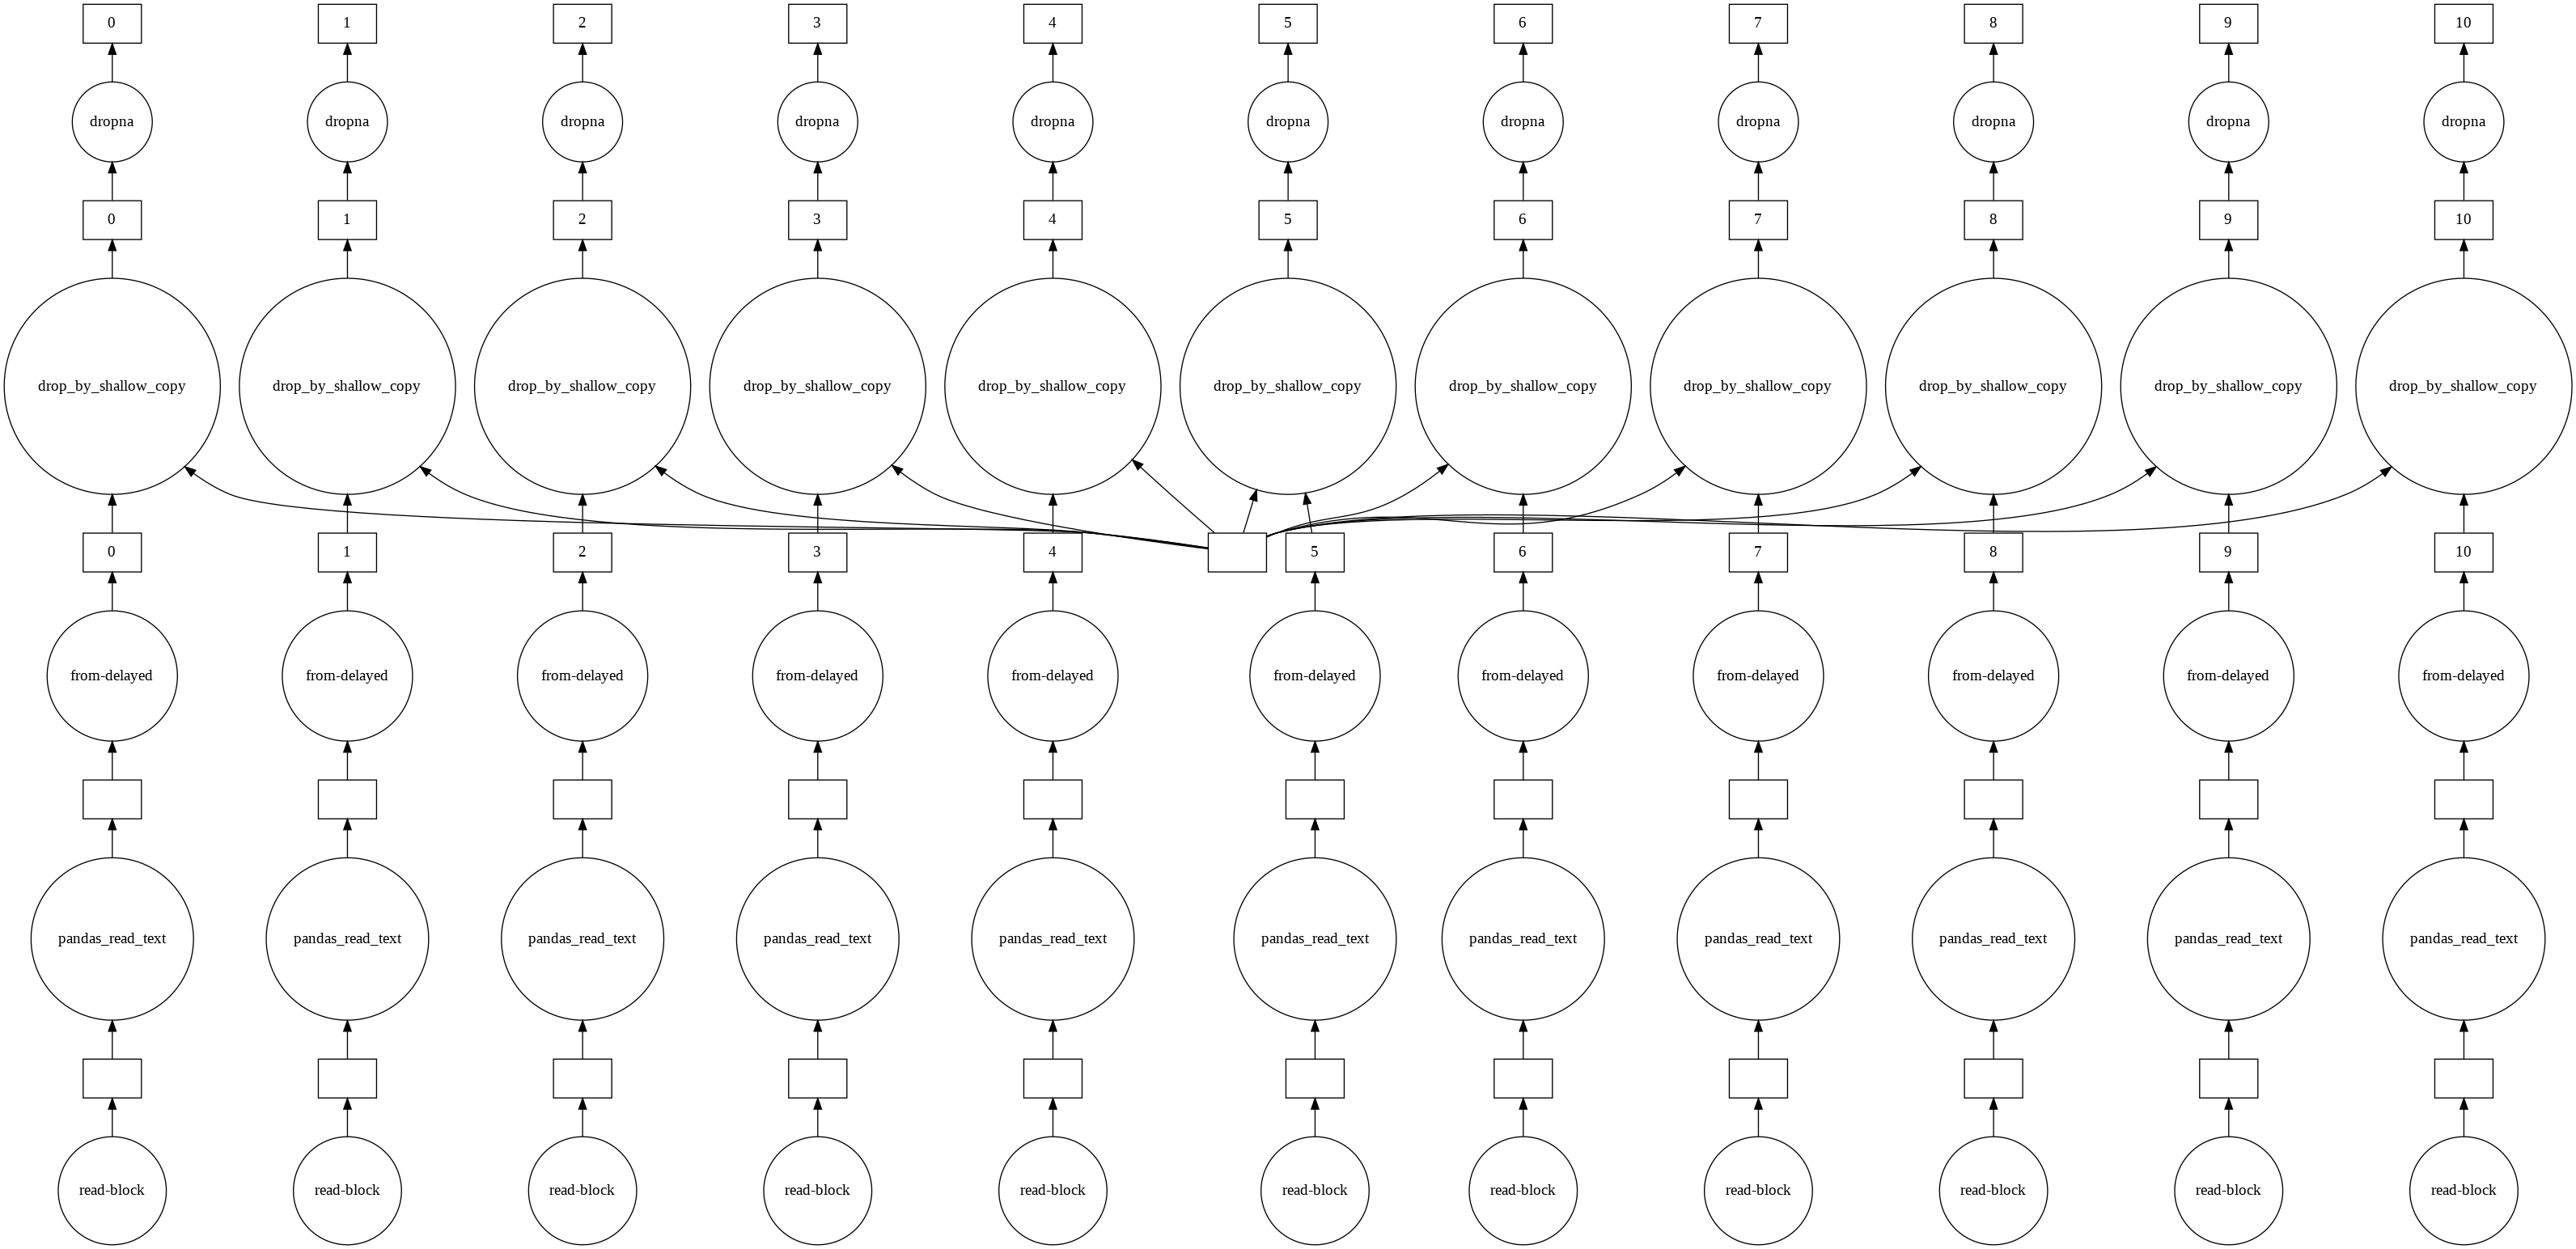

In [31]:
dfDaskClean.visualize()

In [32]:
%time df = dfDaskClean.compute()   # optional

CPU times: user 747 ms, sys: 74.3 ms, total: 821 ms
Wall time: 632 ms


# Vizualizarea datelor 

In [33]:
df.shape           # dupa curatarea datelor am ramas cu 54138 randuri

(68631, 8)

In [34]:
df['Arrest Date'] = pd.to_datetime(df['Arrest Date'], infer_datetime_format=True )
df['Age'] = df['Age'].astype(int)

In [35]:
df = df.loc[(df['Age'] > 18) & (df['Age'] < 100 )]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65526 entries, 1 to 1058
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Report ID                 65526 non-null  int64         
 1   Report Type               65526 non-null  object        
 2   Arrest Date               65526 non-null  datetime64[ns]
 3   Age                       65526 non-null  int64         
 4   Sex Code                  65526 non-null  object        
 5   Charge Group Description  65526 non-null  object        
 6   LAT                       65526 non-null  float64       
 7   LON                       65526 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 4.5+ MB


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'NUmarul de Rapoarte')

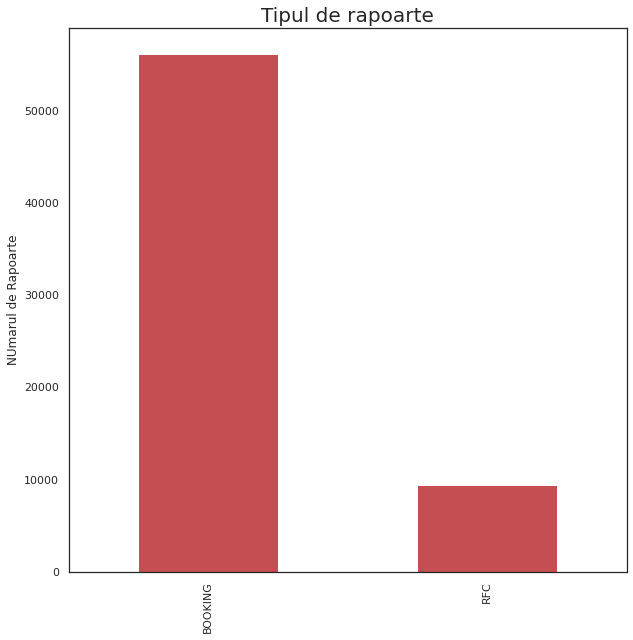

In [38]:
fig = plt.figure(figsize=(10, 10)) 
sns.set(style = 'white')
df['Report Type'].value_counts().plot(kind='bar',color='r',align='center')
plt.title('Tipul de rapoarte', fontsize=20)
plt.ylabel('NUmarul de Rapoarte')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

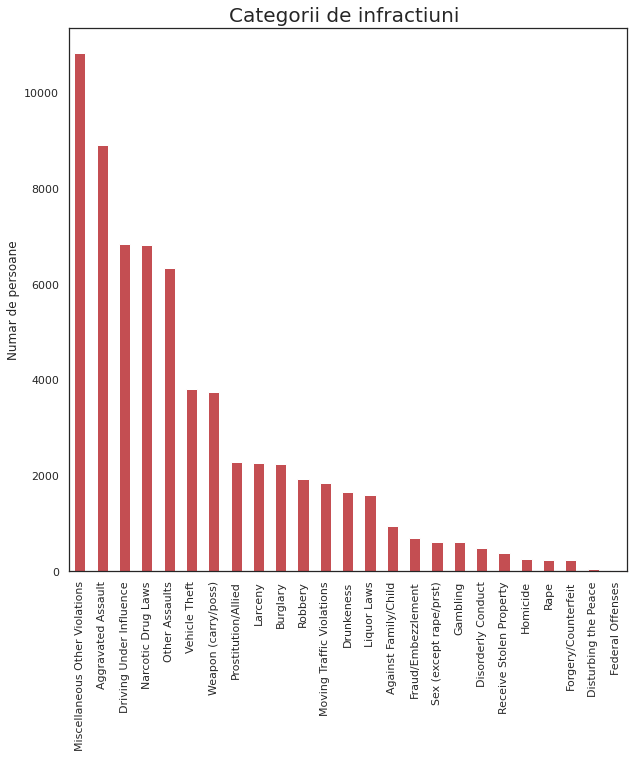

In [39]:
fig = plt.figure(figsize=(10, 10)) 
sns.set(style = 'white')
df['Charge Group Description'].value_counts().plot(kind='bar',color='r',align='center')
plt.title('Categorii de infractiuni ', fontsize=20)
plt.ylabel('Numar de persoane')
plt.xticks(rotation = '90')

In [40]:
df1= df.loc[(df['Charge Group Description'] == 'Driving Under Influence') & (df['Sex Code'] == 'F')]

In [41]:
df1

,Report ID,Report Type,Arrest Date,Age,Sex Code,Charge Group Description,LAT,LON
27,5970400,BOOKING,2020-07-12,29,F,Driving Under Influence,34.1603,-118.4399
80,5961001,BOOKING,2020-06-25,53,F,Driving Under Influence,33.9824,-118.3068
158,5970820,BOOKING,2020-07-12,81,F,Driving Under Influence,34.0766,-118.4547
203,5959743,BOOKING,2020-06-24,36,F,Driving Under Influence,34.2103,-118.4144
428,5960920,BOOKING,2020-06-25,36,F,Driving Under Influence,34.0237,-118.4246
...,...,...,...,...,...,...,...,...
751,6065709,BOOKING,2020-12-07,53,F,Driving Under Influence,34.0480,-118.3493
936,6073749,BOOKING,2020-12-21,52,F,Driving Under Influence,34.1837,-118.4422
953,6071696,BOOKING,2020-12-17,25,F,Driving Under Influence,34.0245,-118.2440
957,6064848,BOOKING,2020-12-06,33,F,Driving Under Influence,34.3009,-118.4696


In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 27 to 1053
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Report ID                 1141 non-null   int64         
 1   Report Type               1141 non-null   object        
 2   Arrest Date               1141 non-null   datetime64[ns]
 3   Age                       1141 non-null   int64         
 4   Sex Code                  1141 non-null   object        
 5   Charge Group Description  1141 non-null   object        
 6   LAT                       1141 non-null   float64       
 7   LON                       1141 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 80.2+ KB


(array([0]), <a list of 1 Text major ticklabel objects>)

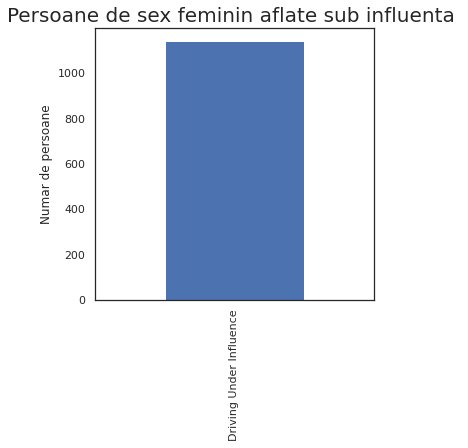

In [43]:
fig = plt.figure(figsize=(5, 5)) 
sns.set(style = 'white')
df1['Charge Group Description'].value_counts().plot(kind='bar',color='b',align='center')
plt.title('Persoane de sex feminin aflate sub influenta ', fontsize=20)
plt.ylabel('Numar de persoane')
plt.xticks(rotation = '90')

In [44]:
old = df[df.Age == df.Age.max()]

In [45]:
old

,Report ID,Report Type,Arrest Date,Age,Sex Code,Charge Group Description,LAT,LON
755,6041140,BOOKING,2020-10-27,95,F,Robbery,34.1766,-118.4589
